<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons/neutron-waveform-extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons/neutron-waveform-extraction.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Radiation Detection Template for Waveform Extraction

In [ ]:
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
import uproot
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # For log normalization

### Step  1 - Root file analysis for waveform extraction

Below we are following the steps to collect the waveform we are interested in looking at from the corresponding root file.

1. Identify time range of interest in the data panel
2. Aggregate and export corresponding .root files from Google Drive storage
3. Download aggregated files
4. Collab analysis!

In [ ]:
'''
Define thresholds for event selection
 psd_threshold: Pulse shape discrimination threshold for neutron identification
 energy_threshold: Energy threshold for event selection
'''

psd_threshold = 0.24
energy_threshold = 260

In [ ]:
file_path = "http://nucleonics.mit.edu/scripts/mergedrootfiles/Computers-thinkpad-t480s-NaI-RAW_20250305_1600_to_20250305_1630/merged_CH0_20250305_1600_to_20250305_1630.root"

file = uproot.open(file_path)

tree = file["Data_R"]  # Make sure this matches the name of the tree in your .root file

file_keys = file.keys()
file_keys

['Data_R;1']

In [ ]:
# Access the "Data_R" tree and list its branches
branches = tree.keys()
branches

['Channel',
 'Timestamp',
 'Board',
 'Energy',
 'EnergyShort',
 'Flags',
 'Probe',
 'Samples']

In [ ]:
# Specify the leaves you want to extract
keys = ["Timestamp", "Energy", "EnergyShort"]
df = tree.arrays(keys, library="pd")  # Cast the leaves into a pandas DataFrame

# Convert Timestamp from picoseconds to seconds
df["Timestamp"] = df["Timestamp"] / 1e12

# Calculate the PSD value
df["PSD"] = (df["Energy"] - df["EnergyShort"]) / df["Energy"]

### Step 2 - Seperating Gamma and Neutron Events with PSD threshold

We plot PSD against ADC channel to distinguish neutron counts from background signals. The red dahsed line in the plot corresponds to the Pulse Shape Discrimination (PSD) threshold we defined earlier. We will consider counts above the line as Neutron counts and those below the line as gamma events.

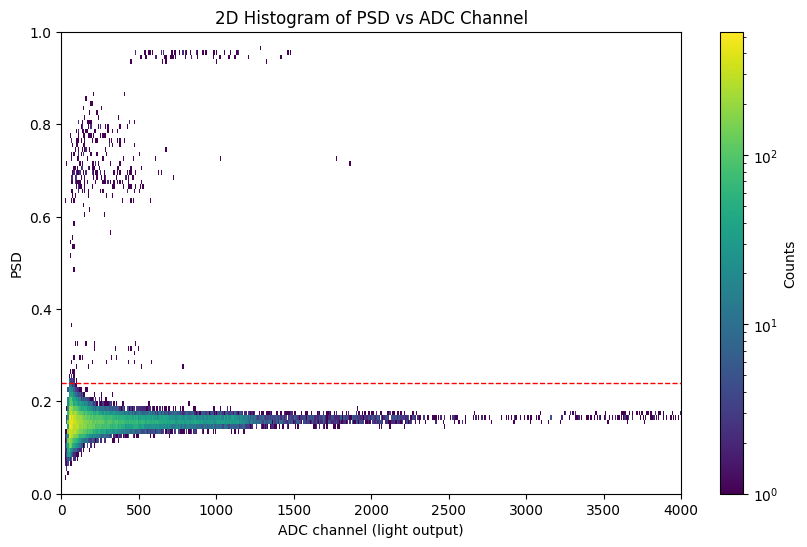

In [ ]:
# Create the 2D histogram
plt.figure(figsize=(10, 6))
H, energy_bins, psd_bins = np.histogram2d(df["Energy"], df["PSD"], bins=(512, 100), range=((0, 4000), (0, 1)))

# Plot the histogram with log normalization
plt.pcolormesh(energy_bins, psd_bins, H.T, norm=mcolors.LogNorm(), cmap='viridis', shading='auto')
plt.colorbar(label='Counts')

# Add a horizontal line at the desired PSD value
plt.axhline(y=psd_threshold, color='red', linestyle='--', linewidth=1)  # Modify y, color, linestyle, and linewidth as needed

# Label the axes
plt.xlabel("ADC channel (light output)")
plt.ylabel("PSD")
plt.title("2D Histogram of PSD vs ADC Channel")
plt.show()

Now with this information, we will keep only the desireable "neutron-like" pulses i.e. where the PSD exceeds the threshold.  

In [ ]:
# Filter the DataFrame to keep only pulses with PSD > threshold
filtered_df = df[df["PSD"] > psd_threshold]

# Check the first few rows of the filtered DataFrame
filtered_df

,Timestamp,Energy,EnergyShort,PSD
3060,669358.458383,435,300,0.310345
6255,669471.122984,474,328,0.308017
6531,669480.500974,79,59,0.253165
7101,669501.631656,433,310,0.284065
9970,669604.675963,74,56,0.243243
...,...,...,...,...
47490,670941.908731,79,60,0.240506
47875,670955.911952,446,306,0.313901
49325,671009.074495,61,46,0.245902
49598,671018.993552,73,54,0.260274


In [ ]:
# Filter the DataFrame to keep only pulses with energy energy_threshold
filtered_df = filtered_df[filtered_df["Energy"] > energy_threshold]

# Check the first few rows of the filtered DataFrame
filtered_df

,Timestamp,Energy,EnergyShort,PSD
3060,669358.458383,435,300,0.310345
6255,669471.122984,474,328,0.308017
7101,669501.631656,433,310,0.284065
26040,670179.887169,1029,278,0.729835
26041,670179.887352,316,138,0.563291
...,...,...,...,...
44197,670821.196023,471,336,0.286624
45094,670854.973058,291,78,0.731959
45186,670858.118814,356,251,0.294944
47006,670923.893740,499,344,0.310621


### Step 3 - Time History of Neutron Bursts/ Identifying time-region of interest

We now want to better identify when we observed a neutron burst. In order to do this, we will create a time history plot of neutron counts per second.

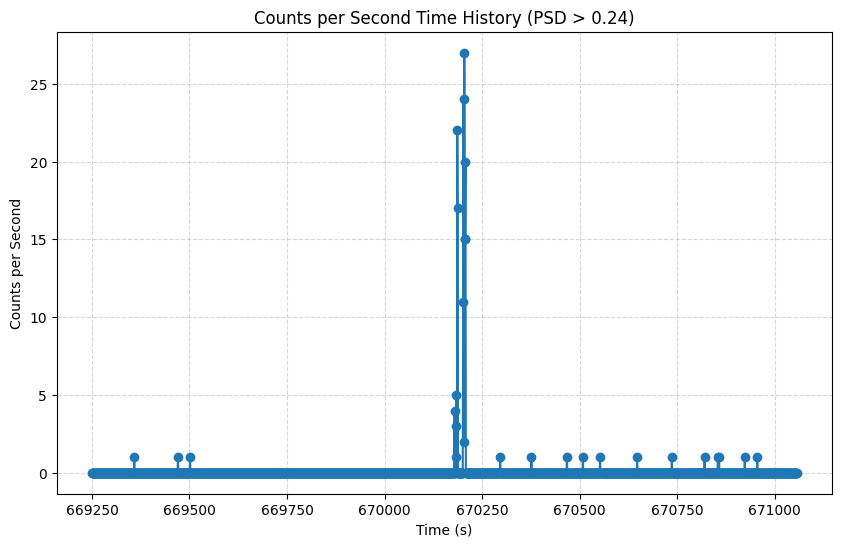

In [ ]:
# To create a time history of counts per second, we will first bin the timestamps by each second
# and then count the number of pulses in each bin

# Bin the timestamps by second
time_bins = np.arange(df["Timestamp"].min(), df["Timestamp"].max() + 1, 1)  # Create 1-second bins
counts_per_second, _ = np.histogram(filtered_df["Timestamp"], bins=time_bins)

# Plot the counts per second
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], counts_per_second, marker='o', linestyle='-')
plt.title("Counts per Second Time History (PSD > 0.24)")
plt.xlabel("Time (s)")
plt.ylabel("Counts per Second")
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

### Step 4 - Look into energy spectrum of filtered pulses

We are now interested in visualizing the distribution of detected energy values (i.e. those above the PSD threshold). In this way, we can check that what we have charactiereized as neutron-like counts show a characteristic neutron energy distribution.

Potential reference spectrum:
- Broad distribution with a tail
- Low energy cutoff
- no photopeaks (gamma)

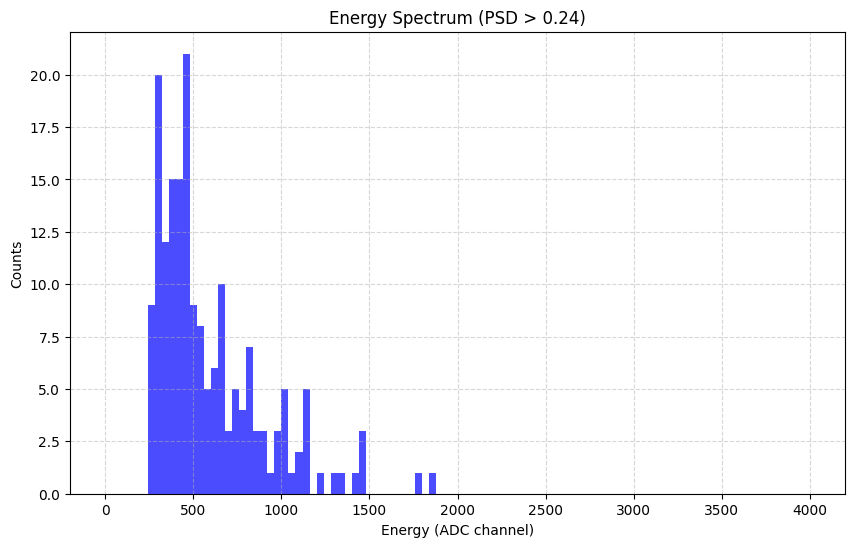

In [ ]:
# To plot the energy spectrum of the filtered pulses
plt.figure(figsize=(10, 6))
plt.hist(filtered_df["Energy"], bins=100, range=(0, 4000), color='blue', alpha=0.7)
plt.title("Energy Spectrum (PSD > 0.24)")
plt.xlabel("Energy (ADC channel)")
plt.ylabel("Counts")
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

### Step 5 - Plot waveforms of neutron counts in burst region of interest

In [ ]:
# Extract the indices of the pulses that meet the condition PSD > 0.24
filtered_indices = filtered_df.index

In [ ]:
# Define the new time window
# We are now focusing on the spcific event cluster time region
time_window_center = 670200
time_window_start = time_window_center - 20
time_window_end = time_window_center + 15

plot_xlim_start = 670000
plot_xlim_end = 670500

We have now identified a time-region of interest and filtered pulses within this time-window. We want to further analyze these pulses. In order to do so , we will extract and plot the corresponding waveforms.

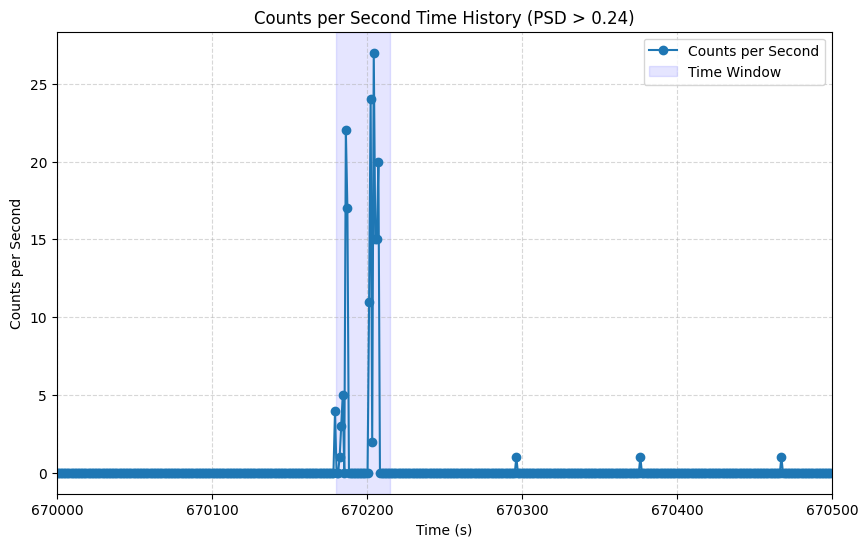

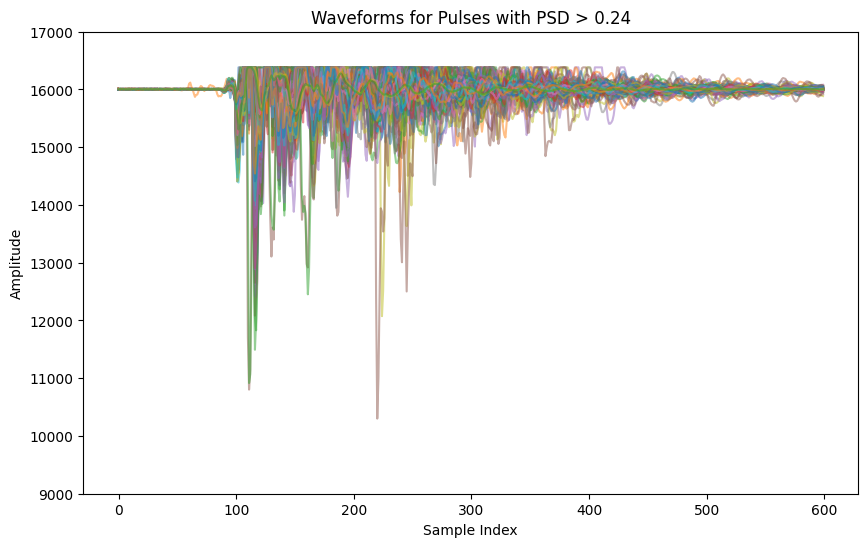

In [ ]:
# Bin the timestamps by second
time_bins = np.arange(df["Timestamp"].min(), df["Timestamp"].max() + 1, 1)  # Create 1-second bins
counts_per_second, _ = np.histogram(filtered_df["Timestamp"], bins=time_bins)

# Plot the counts per second
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], counts_per_second, marker='o', linestyle='-', label="Counts per Second")

# Add a semi-transparent rectangle for the time window
plt.axvspan(time_window_start, time_window_end, color='blue', alpha=0.1, label="Time Window")

# Apply x-axis limits
plt.xlim(plot_xlim_start, plot_xlim_end)

plt.title("Counts per Second Time History (PSD > 0.24)")
plt.xlabel("Time (s)")
plt.ylabel("Counts per Second")
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Filter the pulses within the time window
pulses_in_window = filtered_df[(filtered_df["Timestamp"] >= time_window_start) & (filtered_df["Timestamp"] <= time_window_end)]

filtered_indices = pulses_in_window.index

# Extract only the waveforms corresponding to filtered_indices
selected_waveforms = tree["Samples"].array(entry_start=min(filtered_indices), entry_stop=max(filtered_indices) + 1)

# Plot the waveforms for the filtered pulses
plt.figure(figsize=(10, 6))
for idx in filtered_indices:
    relative_idx = idx - min(filtered_indices)  # Adjust index to match the sliced array
    plt.plot(selected_waveforms[relative_idx], alpha=0.5)

plt.title("Waveforms for Pulses with PSD > 0.24")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim(9000, 17000)
plt.show()